In [2]:
import os
os.chdir('/home/shashank/code/packages/diff-dope')
import matplotlib.pyplot as plt
import hydra
from icecream import ic
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
import numpy as np
from theseus.geometry import SO3
import torch
import pybullet as p
from scipy.spatial.transform import Rotation
import diffdope as dd
from diffdope.pcd_utils import *
from diffdope import *
import math
import meshcat
import meshcat.geometry as mcg
from typing import List, Tuple
import cv2
import trimesh
import open3d as o3d
cname = "myscene_dope"
with initialize(version_base=None, config_path="../configs/"):
    cfg = compose(config_name=cname)

mc_vis = meshcat.Visualizer(zmq_url='tcp://127.0.0.1:6000')
mc_vis.delete()

/home/shashank/miniconda3/envs/rpdiff-env/lib/python3.8/site-packages/theseus/_version.py:30: FutureWarning: Using torch < 2.0 for theseus is deprecated and compatibility will be discontinued in future releases.
  warnings.warn(
pybullet build time: May 20 2022 19:44:17



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
def noise_pose(gt_pos,gt_rot,sigma_t,sigma_r):
    p = torch.from_numpy(gt_pos).float()
    R = torch.from_numpy(Rotation.from_quat(gt_rot).as_matrix()).float()
    nr = torch.randn(1,3) * sigma_r
    nR = torch.matmul(SO3().exp_map(nr).to_matrix(),R)
    nP = torch.randn_like(p) * sigma_t + p
    npose = np.zeros((7,))
    npose[:3] = nP.numpy()
    npose[3:] = Rotation.from_matrix(nR.numpy()).as_quat()
    return npose

def pose_to_T44(p,q):
    t = np.eye(4)
    t[:3,-1] = p
    if len(q) == 4:
        t[:3,:3] = Rotation.from_quat(q).as_matrix()
    if len(q) == 3:
        t[:3,:3] = SO3().exp_map(torch.from_numpy(q).view(-1,3)).to_matrix().numpy()
    return t
def T44_to_pose(T):
    pose = np.zeros((7,))
    pose[:3] = T[:3,-1]
    pose[3:] = Rotation.from_matrix(T[:3,:3]).as_quat()
    return pose

### For our data

{1: 'tray', 2: '051_large_clamp', 3: '009_gelatin_box', 4: '037_scissors', 5: '021_bleach_cleanser', 6: '002_master_chef_can', 7: '008_pudding_box', 8: '052_extra_large_clamp', 9: '019_pitcher_base', 10: '036_wood_block'}


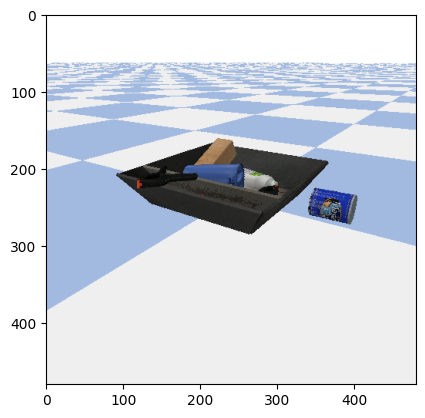

In [6]:
parent_id = '110'
file_path = '/home/shashank/code/packages/rpdiff/src/rpdiff/data/task_demos/cluttered_tabletop/0/'
dfile = np.load(file_path + f'{parent_id}.npz',allow_pickle=True)[parent_id].item()
print(dfile['objects'])
plt.imshow(dfile['img_arr'][0])

In [7]:
#which objects invisible in the scene? 
visible = np.unique(dfile['img_arr'][2])
invisible = list(set(dfile['objects'].keys()).difference(set(visible)))
print(invisible)

[4]


In [28]:
object_id = 4
object_name = dfile['objects'][object_id]
print(f'{object_id}:{object_name}')
model_path = f'/home/shashank/code/packages/rpdiff/src/rpdiff/assets/ycb/{object_name}/textured_simple.obj'
opcd = np.asarray(o3d.io.read_triangle_mesh(model_path).sample_points_uniformly(500).points)
omesh = trimesh.load(model_path)

9:006_mustard_bottle


In [29]:
camera_info = dfile['camera_info']
view_matrix = p.computeViewMatrix(camera_info['cam_eye'],camera_info['lookat'],camera_info['up'])
view_matrix = np.asarray(view_matrix,order='F').reshape([4,4],order='F')
inv_view_matrix = np.linalg.inv(view_matrix)
poses = dfile['poses']
gt_pose_world = np.array(poses[object_name])[0]
gt_pose_world = pose_to_T44(gt_pose_world[:3],gt_pose_world[3:])
# R_obj_wrt_cam = np.matmul(view_matrix[:3,:3],gt_pose_world[:3,:3])
# gt_pose_cam_t44 = np.eye(4)
# gt_pose_cam_t44[:3,:3] = R_obj_wrt_cam
# gt_pose_cam_t44[:3,-1] = gt_pose_world[:3,-1] - view_matrix[:3,-1]
gt_pose_cam_t44 = np.matmul(view_matrix,gt_pose_world)
gt_pose_cam_rtheta = SO3(tensor=torch.from_numpy(gt_pose_cam_t44[:3,:3]).unsqueeze(0)).log_map().squeeze()
gt_pose_cam = T44_to_pose(gt_pose_cam_t44)
print(f'GT Camera Frame position:{gt_pose_cam[:3]}')
print(f'GT Camera Frame Orientation: {gt_pose_cam[3:]}')
print(f'GT Camera Frame rtheta: {gt_pose_cam_rtheta}')

GT Camera Frame position:[ 1.30281529e-01 -7.15135563e-04 -1.05640656e+00]
GT Camera Frame Orientation: [ 0.28498982  0.80718416  0.46730446 -0.22104542]
GT Camera Frame rtheta: tensor([-0.7878, -2.2312, -1.2917], dtype=torch.float64)


#meshcat_frame_show(mc_vis,'camera',transform=inv_view_matrix)
obs_cam = np.matmul(view_matrix[:3,:3],dfile['obs']['points'].T).T + view_matrix[:3,-1]
#meshcat_pcd_show(mc_vis,dfile['obs']['points'],(0,255,0), 'obs_world')
meshcat_frame_show(mc_vis,'camera_v',transform=np.eye(4))

In [30]:
#torch.manual_seed(42)
sigma_r = 0.0
sigma_t = 0.0

In [31]:
noised_pose = noise_pose(gt_pose_cam[:3],gt_pose_cam[3:],sigma_t,sigma_r)
position = noised_pose[:3]
rotation = noised_pose[3:]
#position = np.array([-0.05184132, -0.13659684, -0.87045532]) #drill9
#rotation: np.array([ 0.64350619, -0.50974136,  0.32807912,  0.46736242])

#position =  np.array([-0.04933013,  0.12268861, -1.16658425]) #clamp 9
#rotation = np.array([0.29040092, -0.39217858,  0.55643616,  0.67248946])
#position[0]-=0.3
#position[1]+=0.3
position[2]-=0.3

In [32]:
print(f'Noised Position: {position}')
print(f'Noised Rotation: {rotation}')
#obj_cam = np.matmul(gt_pose_cam_t44[:3,:3],opcd.T).T+gt_pose_cam_t44[:3,-1]
pt44 = pose_to_T44(position,rotation)
obj_cam = np.matmul(pt44[:3,:3],opcd.T).T + pt44[:3,-1]
obj_world = np.matmul(gt_pose_world[:3,:3],opcd.T).T+gt_pose_world[:3,-1]
meshcat_pcd_show(mc_vis,obj_cam,(255,0,255),'obj_cam')
obs_cam = np.matmul(view_matrix[:3,:3],dfile['obs']['points'].T).T + view_matrix[:3,-1]
meshcat_pcd_show(mc_vis,obs_cam,(255,0,0),'obs_cam')
#meshcat_pcd_show(mc_vis,obj_world,(0,255,255),'obj_world')


Noised Position: [ 1.30281523e-01 -7.15135538e-04 -1.05640662e+00]
Noised Rotation: [ 0.04793486  0.85796543 -0.14293389 -0.49108804]


#### Define Config params

In [33]:
############# CAMERA PARAMS ##############
cfg['camera']['im_height'] = camera_info['height']
cfg['camera']['im_width'] = camera_info['width']
cfg['camera']['znear'] = camera_info['nearVal'] 
cfg['camera']['zfar'] = camera_info['farVal']
cfg['camera']['fov'] = camera_info['fov']
############ INITIAL POSE ################
cfg['object3d']['position'] = position.tolist()
cfg['object3d']['rotation'] = rotation.tolist()
cfg['object3d']['refine_translation'] = False
cfg['object3d']['rotation_mode'] = 'rtheta'
############# DATA PARAMS ###################
cfg['scene']['dataset_path'] = file_path
cfg['scene']['parent_id'] = parent_id
cfg['scene']['object_id'] = object_id
cfg['scene']['image_resize'] = 1.0
cfg['object3d']['model_path'] = model_path
############################################
cfg['render_images']['crop_around_mask'] = True
############# LOSS PARAMS ###################
cfg['losses']['l1_rgb_with_mask']= True
cfg['losses']['weight_rgb']= 0.0
cfg['losses']['l1_depth_with_mask']= True
cfg['losses']['weight_depth']= 0.0
cfg['losses']['l1_mask']= True
cfg['losses']['weight_mask']= 0.0
cfg['losses']['l1_reconstruct_depth_with_mask']= True
cfg['losses']['weight_reconstruct']= 100.0
cfg['losses']['stage_ratio'] = 0.5
############# HYPERPARAMS###################
cfg['hyperparameters']['nb_iterations'] = 100
cfg['hyperparameters']['batchsize'] = 16
cfg['hyperparameters']['base_lr_pr'] = [0.5,7]
cfg['hyperparameters']['base_lr'] = 0.5
cfg['hyperparameters']['learning_rate_base_position'] = 1
cfg['hyperparameters']['learning_rate_base'] = 7
cfg['hyperparameters']['learning_rate_base_rotation'] = 7
cfg['hyperparameters']['learning_rates_bound'] = [1,15]
cfg['hyperparameters']['learning_rates_bound_position'] = [0.01, 2]
cfg['hyperparameters']['learning_rates_bound_rotation'] = [1, 15]
cfg['hyperparameters']['lr_decay'] = 0.5
cfg['hyperparameters']['rotation_grad_scale'] = 1.0

[11.899616665849528, 7.718649843262035, 5.733756392773435, 6.975344825762958, 12.594843451801863, 12.58328376806687, 14.074825395848691, 13.452663563511534, 12.78756757388012, 14.64437919530652, 11.701261084855048, 10.115633373192376, 10.35667509388199, 11.518322554014569, 7.717671387824148, 14.292461884208933]
Loss at Ground Truth:
GT Raw RGB Loss:0.009430103935301304
GT Raw Depth Loss:0.00014166199252940714
GT Raw Reconstruction Loss:6.565336207131622e-06
GT Raw Mask Loss:0.01990881748497486


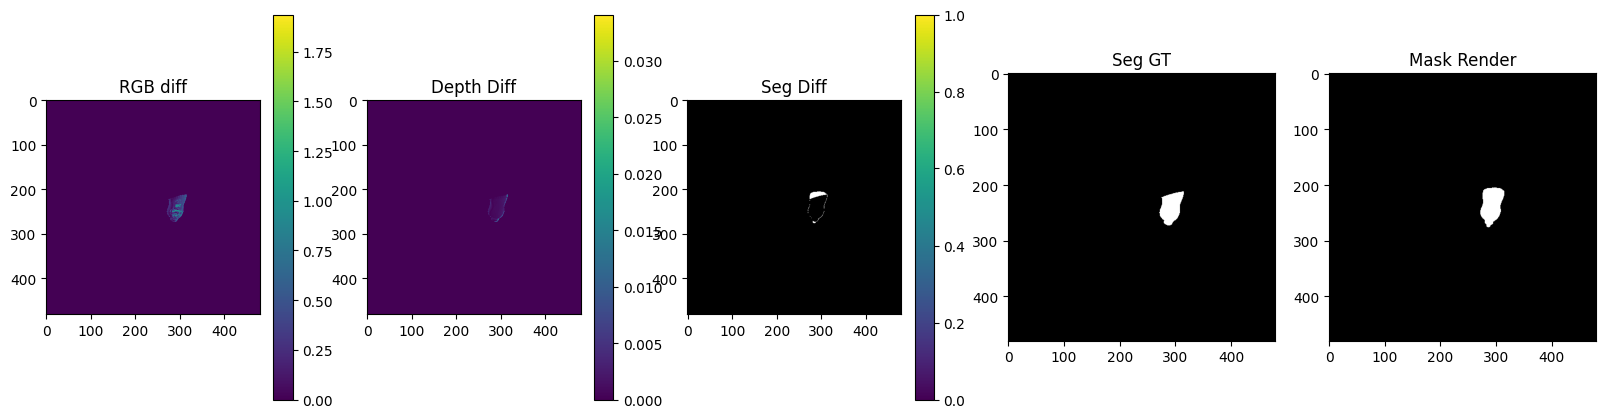

In [34]:
cfg_gt = cfg.copy()
cfg_gt['object3d']['position'] = gt_pose_cam[:3].tolist()
cfg_gt['object3d']['rotation'] = gt_pose_cam[3:].tolist()
ddope_gt = dd.DiffDope(cfg=cfg_gt)
ddope_gt.gt_tensors["rgb"] = ddope_gt.scene.tensor_rgb.img_tensor
ddope_gt.gt_tensors["depth"] = ddope_gt.scene.tensor_depth.img_tensor
ddope_gt.gt_tensors["segmentation"] = ddope_gt.scene.tensor_segmentation.img_tensor

result = ddope_gt.object3d()

if ddope_gt.object3d.rotation_mode == 'rtheta':
    mtx_gu = dd.matrix_batch_44_from_position_r(
        p=result['trans'], r=result['rtheta']
    )
else:
    mtx_gu = dd.matrix_batch_44_from_position_quat(
        p=result['trans'], q=result['quat']
    )
ddope_gt.renders = dd.render_texture_batch(
    glctx=ddope_gt.glctx,
    proj_cam=ddope_gt.camera.cam_proj,
    mtx=mtx_gu,
    pos=result["pos"],
    pos_idx=result["pos_idx"],
    uv=result["uv"],
    uv_idx=result["uv_idx"],
    tex=result["tex"],
    resolution=ddope_gt.resolution,
)
losses = ['rgb','depth','mask']
loss = torch.zeros(ddope_gt.batchsize).cuda()
to_add = {}
to_add["rgb"] = ddope_gt.renders["rgb"].detach().cpu()
to_add["depth"] = ddope_gt.renders["depth"].detach().cpu()
to_add["mtx"] = mtx_gu.detach().cpu()
ddope_gt.optimization_results.append(to_add)
print("Loss at Ground Truth:")
for i,loss_function in enumerate(ddope_gt.loss_functions):
    l = loss_function(ddope_gt)
    if l is None:
        continue
    loss += l

gt_rgb_loss = ddope_gt.losses_values['rgb'].squeeze()[0]
gt_depth_loss = ddope_gt.losses_values['depth'].squeeze()[0]
gt_reconstruct_loss = ddope_gt.losses_values['reconstructed_depth'].squeeze()[0]
gt_mask_loss = ddope_gt.losses_values['mask_selection'].squeeze()[0]
print(f"GT Raw RGB Loss:{gt_rgb_loss}")
print(f"GT Raw Depth Loss:{gt_depth_loss}")
print(f"GT Raw Reconstruction Loss:{gt_reconstruct_loss}")
print(f"GT Raw Mask Loss:{gt_mask_loss}")

diff_rgb = torch.abs(
        (ddope_gt.renders["rgb"] - ddope_gt.gt_tensors["rgb"])
        * ddope_gt.gt_tensors["segmentation"]
    )
diff_depth = torch.abs(
        (ddope_gt.renders["depth"] - ddope_gt.gt_tensors["depth"])
        * ddope_gt.gt_tensors["segmentation"][..., 0]
    )

mask = ddope_gt.renders["mask"]
diff_mask = torch.abs(mask - ddope_gt.gt_tensors["segmentation"])

fig,axes = plt.subplots(1,5,figsize=(20,5))
axes[0].set_title('RGB diff')
axes[1].set_title('Depth Diff')
axes[2].set_title('Seg Diff')
axes[3].set_title('Seg GT')
axes[4].set_title('Mask Render')

drgb = axes[0].imshow(diff_rgb[0].sum(-1).cpu().detach().numpy())
dde = axes[1].imshow(diff_depth[0].cpu().detach().numpy())
dm = axes[2].imshow(diff_mask[0].cpu().detach().numpy())
axes[3].imshow(ddope_gt.gt_tensors["segmentation"][0].cpu().detach().numpy())
axes[4].imshow(mask[0].cpu().detach().numpy())

plt.colorbar(drgb,ax=axes[0])
plt.colorbar(dde,ax=axes[1])
plt.colorbar(dm,ax=axes[2])

# img = ddope_gt.render_img(batch_index=0)
# plt.imshow(img)
ddope_gt.optimization_results = []

### Initialize

In [35]:
ddope = dd.DiffDope(cfg=cfg)
B = ddope.batchsize

[11.660370207044894, 4.122695897585219, 2.0984904311056747, 5.058509726230417, 9.188639724120922, 1.8556911548296438, 13.085209241535049, 4.523486362213985, 14.437211300386048, 6.5755888223796415, 12.74787575373667, 12.894426156650354, 14.98976310286171, 9.284816524102661, 5.069921097466096, 9.613641087873606]


In [36]:
result = ddope.object3d()

if ddope.object3d.rotation_mode=='rtheta':
    mtx_gu = dd.matrix_batch_44_from_position_r(
        p=result["trans"], r=result["rtheta"]
    )
else:
    mtx_gu = dd.matrix_batch_44_from_position_quat(
        p=result["trans"], q=result["quat"]
    )
renders = dd.render_texture_batch(
    glctx=ddope.glctx,
    proj_cam=ddope.camera.cam_proj,
    mtx=mtx_gu,
    pos=result["pos"],
    pos_idx=result["pos_idx"],
    uv=result["uv"],
    uv_idx=result["uv_idx"],
    tex=result["tex"],
    resolution=ddope.resolution,   
)

In [37]:
rgb_render = renders['rgb'][0].detach().cpu()
rgb_gt = ddope.gt_tensors["rgb"].cpu()
depth_render = renders['depth'][0].detach().cpu()
depth_gt = ddope.gt_tensors["depth"].cpu()
seg_gt = ddope.gt_tensors["segmentation"].cpu()
mask = renders["mask"][0].detach().cpu()
diff_mask = torch.abs(mask- ddope.gt_tensors["segmentation"].cpu())
#reconst = torch.abs(
#reconst =  depth_gt.clone()
#depth_diff = (torch.min(depth_gt,depth_render)-depth_gt)*mask[...,0]
#reconst = reconst + depth_diff
reconst = torch.where(mask[...,0]>0,torch.min(depth_gt,depth_render),depth_gt)

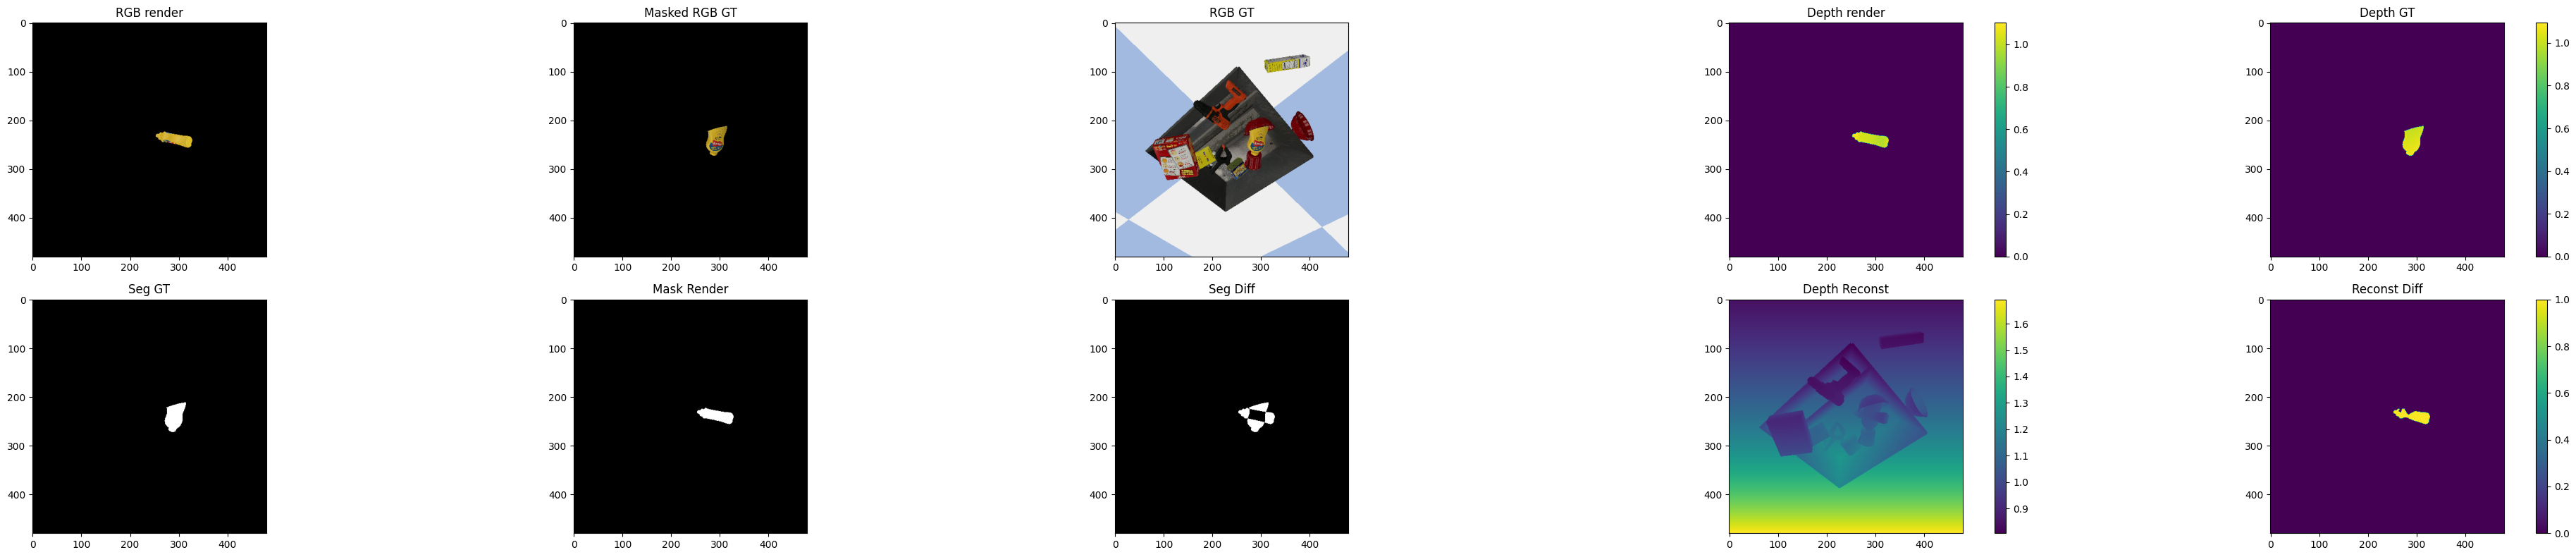

In [38]:
fig, axes = plt.subplots(2, 5, figsize=(40, 8))  # Change the subplot configuration to 2 rows of 5 plots each

# Setting titles for each subplot
titles = [
    'RGB render', 'Masked RGB GT', 'RGB GT', 'Depth render', 'Depth GT',
    'Seg GT', 'Mask Render', 'Seg Diff', 'Depth Reconst','Reconst Diff'
]
for idx, ax in enumerate(axes.flat):
    ax.set_title(titles[idx]) if idx < len(titles) else ax.axis('off')  # Set titles or turn off extra subplot

# Plotting the images
axes[0, 0].imshow(rgb_render.numpy())
axes[0, 1].imshow((rgb_gt * seg_gt).numpy())
axes[0, 2].imshow(rgb_gt.numpy())
dr = axes[0, 3].imshow((depth_render * mask[..., 0]).numpy())
dg = axes[0, 4].imshow((depth_gt * seg_gt[..., 0]).numpy())
axes[1, 0].imshow(seg_gt.numpy())
axes[1, 1].imshow(mask.numpy())
axes[1, 2].imshow(diff_mask.numpy())
drc = axes[1, 3].imshow(reconst.numpy())
ddrc = axes[1,4].imshow((reconst!=depth_gt).numpy())
# Adding colorbars to specific subplots
plt.colorbar(dr, ax=axes[0, 3])
plt.colorbar(dg, ax=axes[0, 4])
plt.colorbar(drc, ax=axes[1, 3])
plt.colorbar(ddrc,ax = axes[1,4])
plt.tight_layout()
plt.show()


### Run Optimization

In [39]:
ddope.run_optimization()

loss: 0.9130: 100%|██████████| 101/101 [00:03<00:00, 27.06it/s]


In [40]:
ddope.run_batched_rp_lr_optimization()
ic(ddope.get_argmin(), ddope.get_pose())
print(f'GT pose:{gt_pose_cam_t44}')

[1.6517512027813972, 0.8244387422328541, 0.22880052523403543, 0.09016654912948957, 1.1608427240462258, 1.419186250534978, 1.770764020309989, 0.5554985334738322, 0.8514046605873298, 0.8648966218912026, 1.8070124937902632, 1.1680014561497623, 1.5520512758091598, 0.4039723535483879, 0.9152228061573395, 0.31733554822219745]
[7.399829799073147, 8.375430247437055, 14.003704166967713, 5.802774913575874, 1.3956582271740865, 8.656093213680595, 1.209724390283151, 6.796171377656492, 8.29474641820535, 2.7466977944967232, 4.823544512833786, 3.7620473210015613, 11.843089529970483, 9.01189907141356, 7.458383366777879, 2.1518124995822103]


loss: 0.4553: 100%|██████████| 101/101 [00:03<00:00, 28.71it/s]
ic| ddope.get_argmin(): tensor(14)
    ddope.get_pose(): array([[-7.1975052e-01,  6.8983328e-01, -7.8034371e-02,  1.3028152e-01],
                             [ 2.8406060e-01,  3.9519924e-01,  8.7357175e-01, -7.1513554e-04],
                             [ 6.3345790e-01,  6.0658729e-01, -4.8039898e-01, -1.0564066e+00],
                             [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
                            dtype=float32)


GT pose:[[-7.39839497e-01  6.66669600e-01 -9.04947105e-02  1.30281529e-01]
 [ 2.53487524e-01  4.00814736e-01  8.80392943e-01 -7.15135563e-04]
 [ 6.23202754e-01  6.28410133e-01 -4.65530944e-01 -1.05640656e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [41]:
#These are now raw loss values
img_plot = ddope.plot_losses()
cv2.imwrite("plot.png", img_plot)
ddope.make_animation(output_file_path="simple_scene.mp4",batch_index=None)
print("Saved animation to simple_scene.mp4")
opt_results = ddope.optimization_results
#params = ['qx','qy','qz','qw','x','y','z']
params = ['rx','ry','rz','x','y','z']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


making video: 100%|██████████| 101/101 [00:06<00:00, 14.74it/s]


Saved animation to simple_scene.mp4


Best RGB Loss: 0.008663391694426537
GT Raw RGB Loss:0.009430103935301304
--------
Best Depth Loss: 0.00017742987256497145
GT Raw Depth Loss:0.00014166199252940714
--------
GT Raw Mask Loss:0.01990881748497486
Best Mask Loss: 0.02041863091289997
GT reconstruction Loss: 6.565336207131622e-06
Best reconstruction Loss: 7.025294962659245e-06


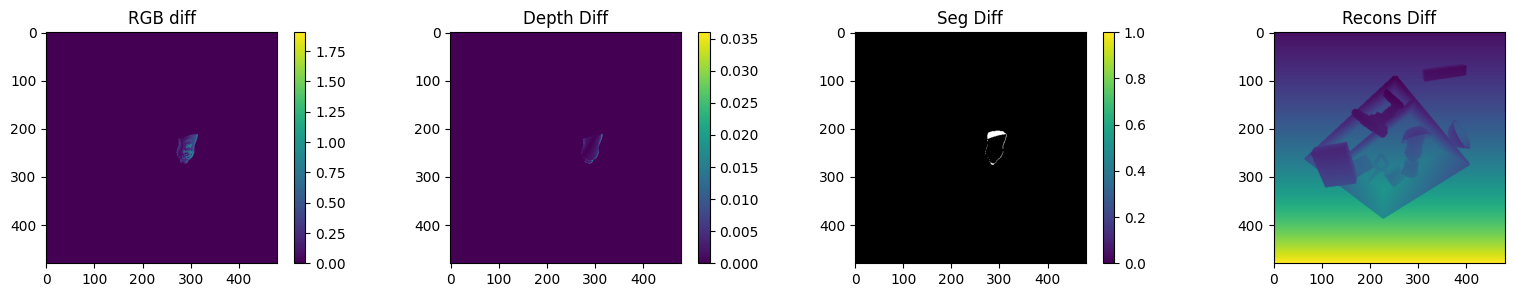

In [42]:
argmi = ddope.get_argmin()
print(f"Best RGB Loss: {ddope.losses_values['rgb'][...,argmi][-1]}")
print(f"GT Raw RGB Loss:{gt_rgb_loss}")
print("--------")
print(f"Best Depth Loss: {ddope.losses_values['depth'][...,argmi][-1]}")
print(f"GT Raw Depth Loss:{gt_depth_loss}")
print("--------")
print(f"GT Raw Mask Loss:{gt_mask_loss}")
print(f"Best Mask Loss: {ddope.losses_values['mask_selection'][...,argmi][-1]}")
print(f"GT reconstruction Loss: {gt_reconstruct_loss}")
print(f"Best reconstruction Loss: {ddope.losses_values['reconstructed_depth'][...,argmi][-1]}")

best_rgb = ddope.optimization_results[-1]['rgb'][argmi].cuda()
best_depth = ddope.optimization_results[-1]['depth'][argmi].cuda()
best_mask = ddope.optimization_results[-1]['mask'][argmi].cuda()

diff_rgb = torch.abs(
        (best_rgb - ddope.gt_tensors["rgb"])
        * ddope.gt_tensors["segmentation"]
    )
diff_depth = torch.abs(
        (best_depth - ddope.gt_tensors["depth"])
        * ddope.gt_tensors["segmentation"][..., 0]
    )
recons = (torch.where(best_mask[...,0]>0,torch.min(ddope.gt_tensors["depth"],best_depth),ddope.gt_tensors["depth"]))#!=ddope.gt_tensors["depth"])

diff_mask = torch.abs(best_mask - ddope.gt_tensors["segmentation"])

fig,axes = plt.subplots(1,4,figsize=(20,3))
axes[0].set_title('RGB diff')
axes[1].set_title('Depth Diff')
axes[2].set_title('Seg Diff')
axes[3].set_title('Recons Diff')

drgb = axes[0].imshow(diff_rgb[0].sum(-1).cpu().detach().numpy())
dde = axes[1].imshow(diff_depth[0].cpu().detach().numpy())
dm = axes[2].imshow(diff_mask[0].cpu().detach().numpy())
axes[3].imshow(recons[0].cpu().detach().numpy())

plt.colorbar(drgb,ax=axes[0])
plt.colorbar(dde,ax=axes[1])
plt.colorbar(dm,ax=axes[2])

In [43]:
best_pose_T44 = ddope.get_pose(get_all=True)

In [44]:
print(best_pose_T44[-1])
for i in range(len(best_pose_T44)):
    meshcat_pcd_show(mc_vis,np.matmul(best_pose_T44[i][:3,:3],opcd.T).T+best_pose_T44[i][:3,-1],(255,255,0),f'intermediate_poses/best_pose_{i}')

meshcat_pcd_show(mc_vis,np.matmul(best_pose_T44[-1][:3,:3],opcd.T).T+best_pose_T44[-1][:3,-1],(255,255,0),f'best_pose')    

[[-7.1975052e-01  6.8983328e-01 -7.8034371e-02  1.3028152e-01]
 [ 2.8406060e-01  3.9519924e-01  8.7357175e-01 -7.1513554e-04]
 [ 6.3345790e-01  6.0658729e-01 -4.8039898e-01 -1.0564066e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


### Visualize Gradients

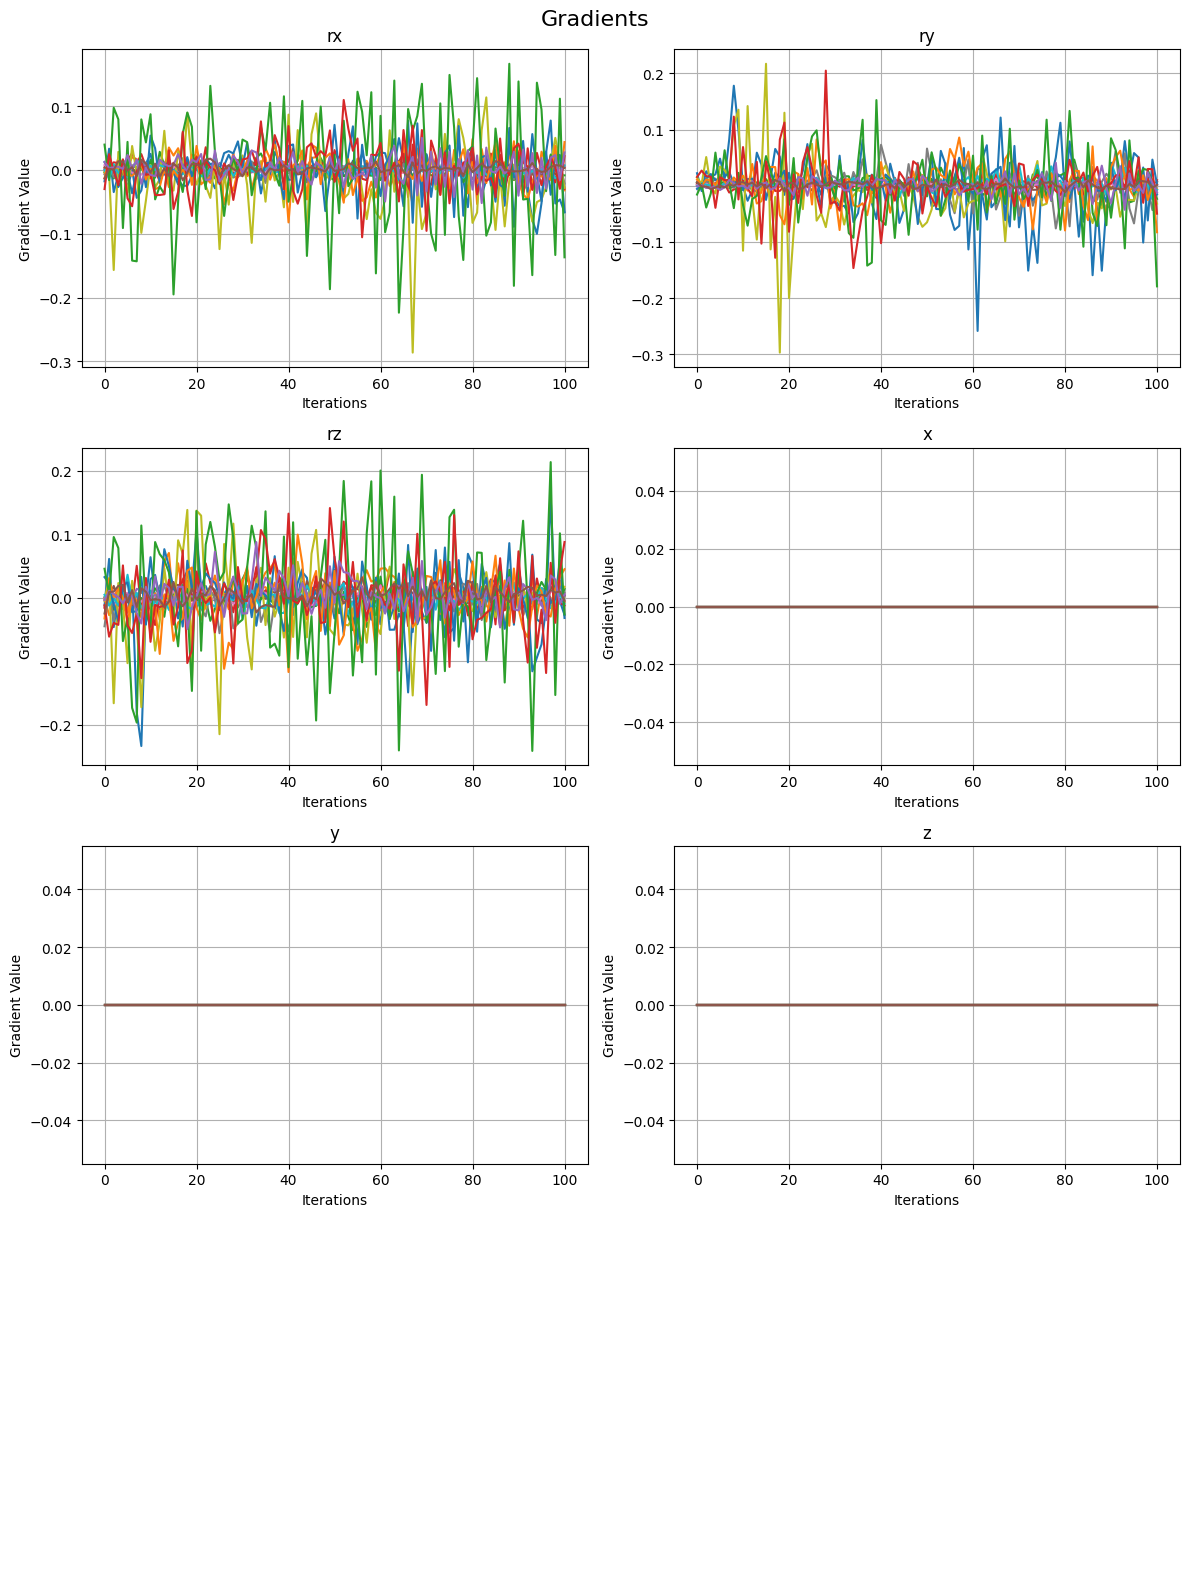

In [45]:
gradients = [o['gradients'].T for o in opt_results]
rows = 4  # Number of rows in the subplot grid
cols = 2 
num_params = len(params)
fig, axs = plt.subplots(rows, cols, figsize=(12, 16))  # Adjust size if needed
fig.suptitle('Gradients', fontsize=16)
for i, ax in enumerate(axs.flatten()):
    if i < num_params:
        param_gradients = [array[:, i] for array in gradients]  # Extract gradients for each parameter
        ax.plot(param_gradients)
        ax.set_title(params[i])
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Gradient Value')
        ax.grid(True)
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()


### Visualize values

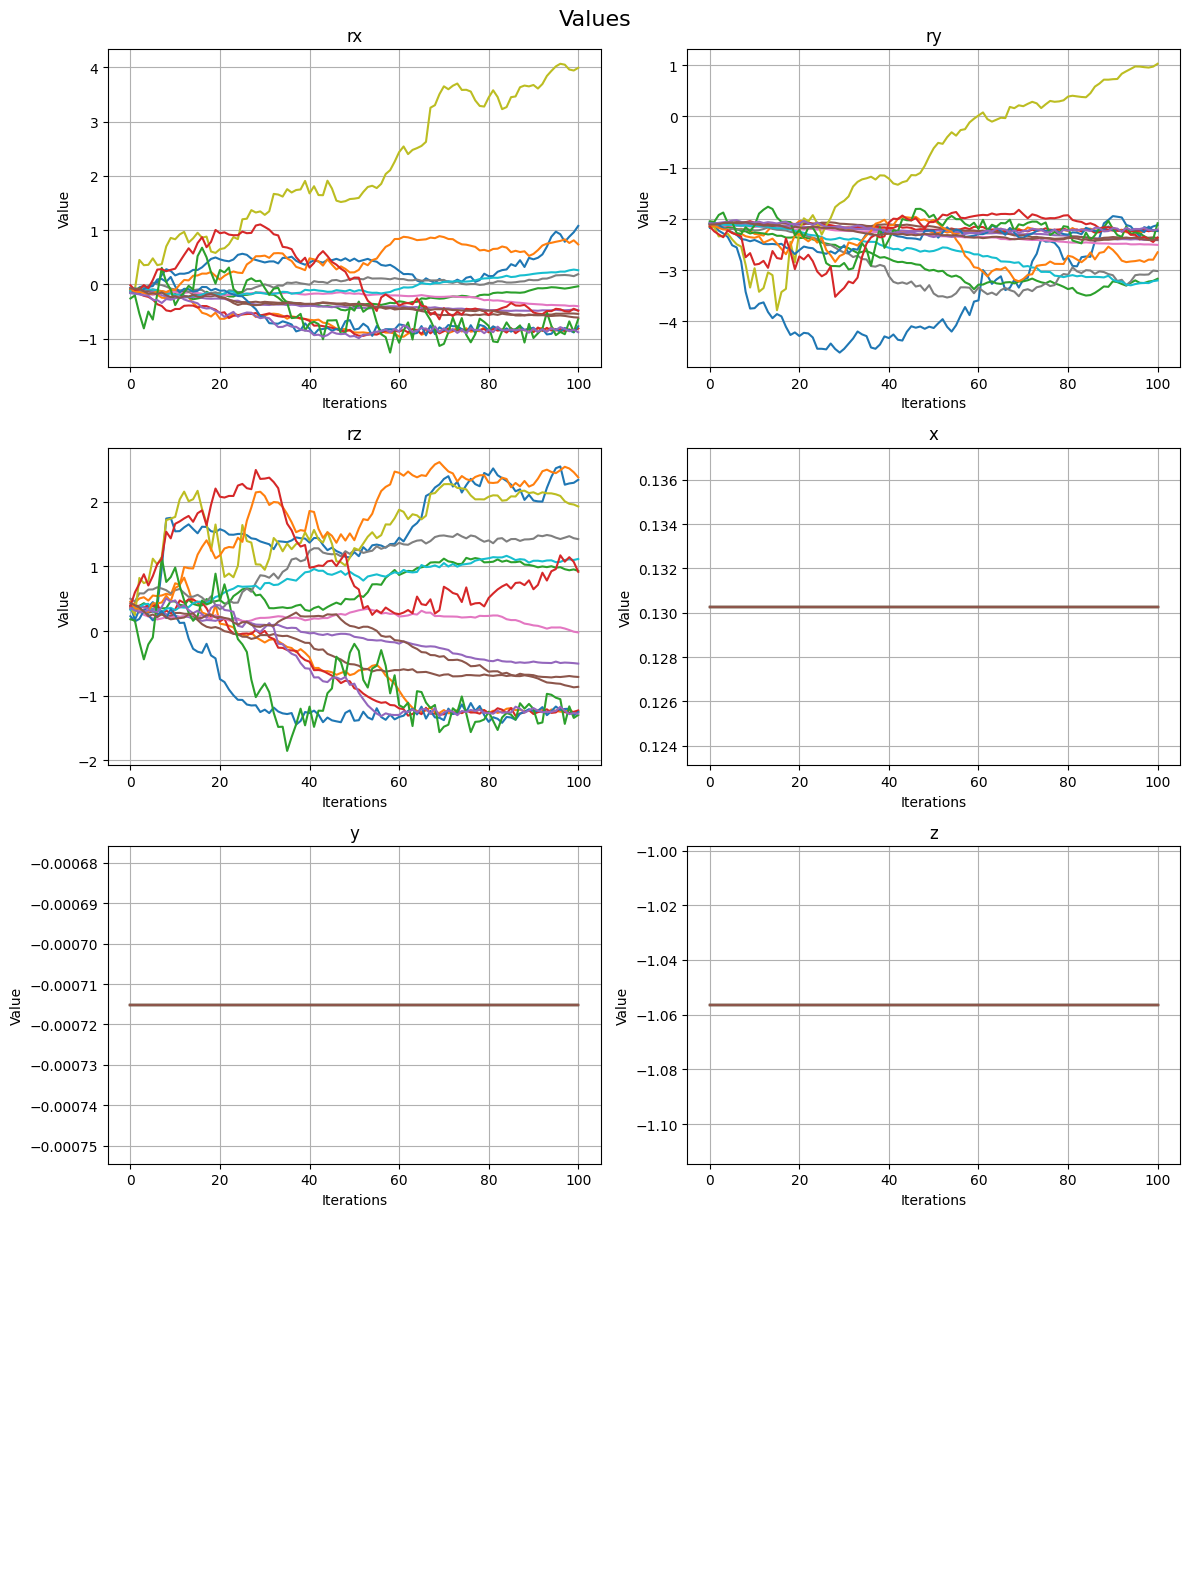

In [46]:
values = [o['values'].T for o in opt_results]
rows = 4  # Number of rows in the subplot grid
cols = 2 
fig, axs = plt.subplots(rows, cols, figsize=(12, 16))  # Adjust size if needed
fig.suptitle('Values', fontsize=16)
for i, ax in enumerate(axs.flatten()):
    if i < num_params:
        param_values = np.array([array[:, i] for array in values])  # Extract gradients for each parameter
        means = param_values.mean(1)
        ax.plot(param_values)
        ax.set_title(params[i])
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Value')
        ax.grid(True)
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()